Cette cellule importe toutes les bibliothèques nécessaires pour :
- Manipuler les données et les chemins (tensorflow,pathlib,..)
- Construire et entraîner le modèle DenseNet121
- Gérer l'entraînement, la sauvegarde, et les callbacks.

In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Configuration des chemins
data_dir = Path("C:/WorkBench/Data/Projet/ZOIDBERG2.0/Travail/Data")
train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

# Paramètres globaux
img_size = (224, 224)
batch_size = 32
seed = 42


Ici, on prépare les datasets d'entraînement et de validation à partir des répertoires d’images.  
Les images sont redimensionnées à 224x224 et organisées automatiquement par label grâce à `image_dataset_from_directory()`.  
On applique aussi un prétraitement automatique (mise en cache et préchargement via `AUTOTUNE`).


In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    label_mode='binary'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    label_mode='binary'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    label_mode='binary'
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 4900 files belonging to 2 classes.
Found 1050 files belonging to 2 classes.
Found 1050 files belonging to 2 classes.


Construction du modèle avec DenseNet121 (Transfer Learning)

Ce modèle est pré-entraîné sur ImageNet, on va :

    Charger les couches convolutives sans la couche finale (include_top=False)

    Les geler pour ne pas les réentraîner (dans un premier temps)

    Ajouter notre propre “tête” de classification

In [3]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Base du modèle DenseNet121 sans la couche de classification
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base_model.trainable = False  # On ne réentraîne pas les couches de base

# Construction du modèle complet
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Pour classification binaire
])


COMPILATION :

Le modèle est compilé avec :
- loss=binary_crossentropy pour la classification binaire
- optimizer=rmsprop
- metrics=['accuracy']

Un ModelCheckpoint est défini pour sauvegarder le modèle à chaque amélioration des performances de validation.

ENTRAINEMENT :

Le modèle est entraîné pendant 5 époques sur les données d'entraînement.  
À chaque époque, on évalue la performance sur le jeu de validation.  
Les performances (accuracy, loss) sont affichées à chaque étape et le modèle est sauvegardé.



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compilation du modèle
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/densenet_model.h5', save_best_only=True)

# Entraînement
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/15


154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6215 - loss: 1.4660

154/154 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.6218 - loss: 1.4638 - val_accuracy: 0.8971 - val_loss: 0.2722
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7875 - loss: 0.5484

154/154 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.7876 - loss: 0.5480 - val_accuracy: 0.9067 - val_loss: 0.2251
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8399 - loss: 0.4054

154/154 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.8400 - loss: 0.4051 - val_accuracy: 0.9162 - val_loss: 0.2062
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8548 - loss: 0.3477

154/154 ━━━━━━━━━━━━━━━━━━━━ 1041s 7s/step - accuracy: 0.8548 - loss: 0.3475 - val_accuracy: 0.9238 - val_loss: 0.1987
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8753 - loss: 0.3118

154/154 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8753 - loss: 0.3118 - val_accuracy: 0.9257 - val_loss: 0.1945
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8758 - loss: 0.2857 - val_accuracy: 0.9200 - val_loss: 0.1963
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8808 - loss: 0.2961

154/154 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.8808 - loss: 0.2960 - val_accuracy: 0.9276 - val_loss: 0.1899
Epoch 8/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8771 - loss: 0.3106

154/154 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.8771 - loss: 0.3104 - val_accuracy: 0.9276 - val_loss: 0.1868
Epoch 9/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.8917 - loss: 0.2844 - val_accuracy: 0.9276 - val_loss: 0.1892
Epoch 10/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 1766s 12s/step - accuracy: 0.8910 - loss: 0.2822 - val_accuracy: 0.9152 - val_loss: 0.1961
Epoch 11/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8815 - loss: 0.2780

154/154 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.8815 - loss: 0.2780 - val_accuracy: 0.9305 - val_loss: 0.1850
Epoch 12/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8900 - loss: 0.2865

154/154 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.8901 - loss: 0.2864 - val_accuracy: 0.9362 - val_loss: 0.1771
Epoch 13/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.8843 - loss: 0.2902 - val_accuracy: 0.9410 - val_loss: 0.1835
Epoch 14/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8868 - loss: 0.2733 - val_accuracy: 0.9133 - val_loss: 0.2028
Epoch 15/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.8886 - loss: 0.2749 - val_accuracy: 0.9105 - val_loss: 0.2042


In [5]:
import os
os.makedirs("models", exist_ok=True)
model.save("models/densenet_model.keras")


Ce graphe affiche l’évolution de la précision (accuracy) et de la perte (loss) du modèle pendant l’entraînement.

À gauche : la courbe de précision (accuracy) pour l’ensemble d’entraînement et de validation à chaque époque.
À droite : la courbe de perte (loss) pour l’ensemble d’entraînement et de validation à chaque époque.

Cela permet de visualiser si le modèle apprend bien, s’il y a du surapprentissage  ou si l’entraînement est stable.

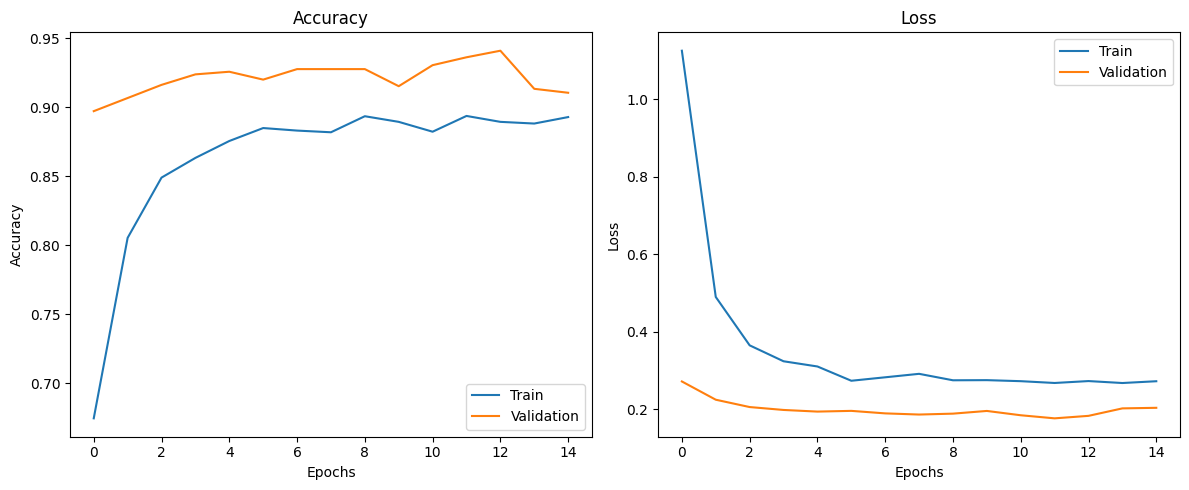

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
